# Packages

In [1]:
import rasterio
import rioxarray as rio
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xcube
from xcube.core.store import new_data_store
import matplotlib.pyplot as plt
import shapely
import geopandas as gpd
import os
import os
import geopandas as gpd
from rasterio.features import geometry_mask
import pandas as pd


# 1. Load Corine and german border data

In [2]:
cube_ger_sample_path = os.path.join("data","cube_sif_sample.tif")


In [3]:
germany_shp_path = os.path.join('data','germany_border.shp')
germany_gpd = gpd.read_file(germany_shp_path)

In [8]:
corine_file_paths = {}
years = [2000,2006,2012,2018]
lc_year_dict = {}
for year in years:
    
    # path for year
    path = os.path.join("data", "landcover",f"forest_cover_{year}.tif")

    # append path to list
    corine_file_paths[year] = path
    # data = rio.open_rasterio(path)
    # lc_year_dict[year] =   data# Assuming you want to read the first band



# 2. ESDS Data

### 2.1 Setup

In [9]:
variables = ["evaporation_era5",
            "precipitation_era5", 
            "radiation_era5", 
            "air_temperature_2m", 
            "max_air_temperature_2m", 
            "min_air_temperature_2m",
            "sif_gosif"]

In [10]:
store = new_data_store("s3", root="deep-esdl-public", storage_options=dict(anon=True))
store.list_data_ids()


cube = store.open_data( 'esdc-8d-0.25deg-256x128x128-3.0.1.zarr')

cube = cube.sel(time=slice('2002-01-01','2021-12-31'))

lon_min, lon_max = 5.866, 15.042
lat_min, lat_max = 47.270, 55.058

cube_ger = cube[variables].sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

In [11]:
summer_data = cube_ger.sif_gosif.sel(time=cube_ger['time.season'] == 'JJA')
summer_mean_per_year = summer_data.groupby('time.year').mean(dim='time')
summer_mean_per_year

summer_mean_to_2017 = summer_mean_per_year.sel(year=slice(None,2017)).mean(dim='year')
summer_mean_2018 = summer_mean_per_year.sel(year = 2018)
summer_mean_2019 = summer_mean_per_year.sel(year = 2019)
summer_mean_2020 = summer_mean_per_year.sel(year = 2020)

In [12]:
diff_18_baseline = summer_mean_2018 - summer_mean_to_2017
diff_19_baseline = summer_mean_2019 - summer_mean_to_2017
diff_20_baseline = summer_mean_2020 - summer_mean_to_2017

### 2.2 Plotting

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

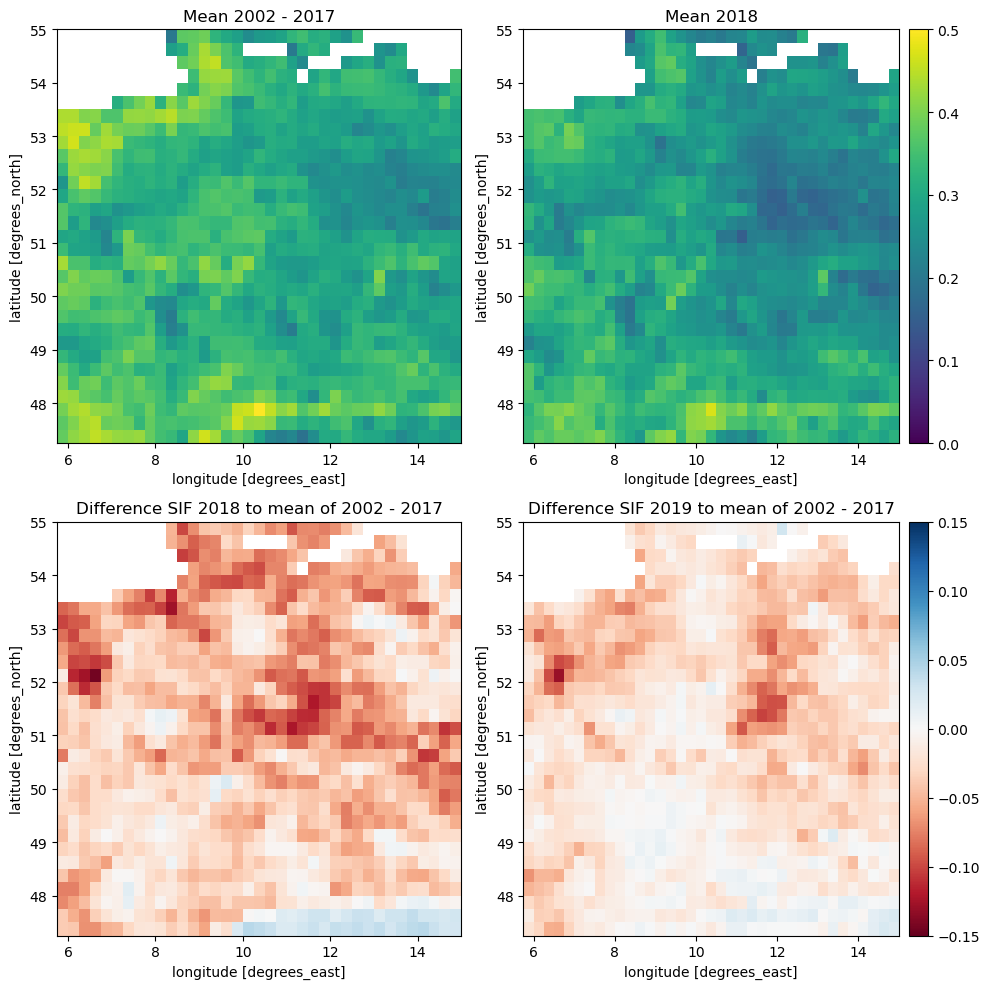

In [14]:

# Create the figure and 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot each time slice on a different subplot
img1 = summer_mean_to_2017.plot(ax=axs[0, 0], cmap="viridis", vmin=0, vmax=0.5, add_colorbar=False)
axs[0, 0].set_title("Mean 2002 - 2017")

img2 = summer_mean_2018.plot(ax=axs[0, 1], cmap="viridis", vmin=0, vmax=0.5, add_colorbar=False)
axs[0, 1].set_title("Mean 2018")

img3 = diff_18_baseline.plot(ax=axs[1, 0], cmap="RdBu", vmin=-0.15, vmax=0.15, add_colorbar=False)
axs[1, 0].set_title("Difference SIF 2018 to mean of 2002 - 2017")

img4 = diff_19_baseline.plot(ax=axs[1, 1], cmap="RdBu", vmin=-0.15, vmax=0.15, add_colorbar=False)
axs[1, 1].set_title("Difference SIF 2019 to mean of 2002 - 2017")

# Add colorbars for each row
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(img2, cax=cax, orientation="vertical")

divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(img4, cax=cax, orientation="vertical")


# Adjust layout for better spacing
plt.tight_layout()
plt.show()


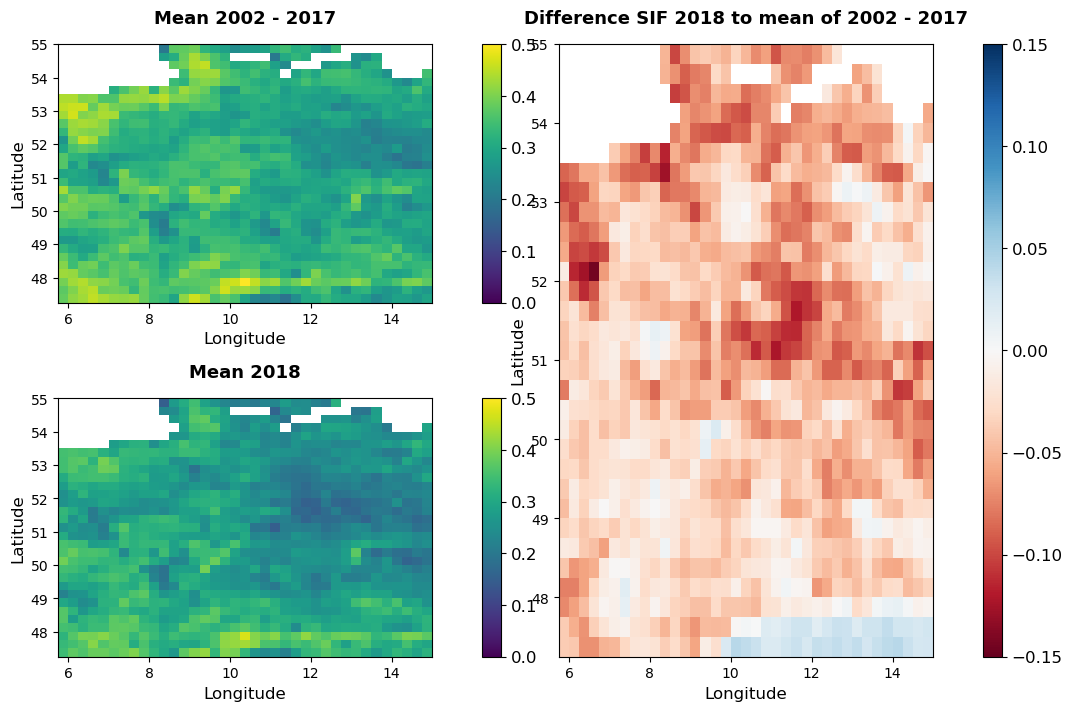

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create the figure and 2x2 subplots
fig, axd = plt.subplot_mosaic([['upleft', 'right'],
                               ['lowleft', 'right']], layout='constrained', figsize=(10, 7))

# Plot each time slice on a different subplot
img1 = summer_mean_to_2017.plot(ax=axd["upleft"], cmap="viridis", vmin=0, vmax=0.5, add_colorbar=False)
axd["upleft"].set_title("Mean 2002 - 2017", fontsize=13, fontweight='bold', pad=15)
axd["upleft"].set_xlabel("Longitude", fontsize=12)
axd["upleft"].set_ylabel("Latitude", fontsize=12)

img2 = summer_mean_2018.plot(ax=axd["lowleft"], cmap="viridis", vmin=0, vmax=0.5, add_colorbar=False)
axd["lowleft"].set_title("Mean 2018", fontsize=13, fontweight='bold', pad=15)
axd["lowleft"].set_xlabel("Longitude", fontsize=12)
axd["lowleft"].set_ylabel("Latitude", fontsize=12)

img3 = diff_18_baseline.plot(ax=axd["right"], cmap="RdBu", vmin=-0.15, vmax=0.15, add_colorbar=False)
axd["right"].set_title("Difference SIF 2018 to mean of 2002 - 2017", fontsize=13, fontweight='bold', pad=15)
axd["right"].set_xlabel("Longitude", fontsize=12)
axd["right"].set_ylabel("Latitude", fontsize=12)

# Add colorbars for each row
divider1 = make_axes_locatable(axd["upleft"])
cax1 = divider1.append_axes("right", size="5%", pad=0.5)
fig.colorbar(img1, cax=cax1, orientation="vertical").ax.tick_params(labelsize=12)

divider2 = make_axes_locatable(axd["lowleft"])
cax2 = divider2.append_axes("right", size="5%", pad=0.5)
fig.colorbar(img2, cax=cax2, orientation="vertical").ax.tick_params(labelsize=12)

divider3 = make_axes_locatable(axd["right"])
cax3 = divider3.append_axes("right", size="5%", pad=0.5)
fig.colorbar(img3, cax=cax3, orientation="vertical").ax.tick_params(labelsize=12)

# Adjust layout for better spacing
# plt.tight_layout(pad=6.0)

# Save the figure to inspect improvements
plt.savefig('plots/enhanced_plot.png', dpi=300, bbox_inches='tight')

plt.show()


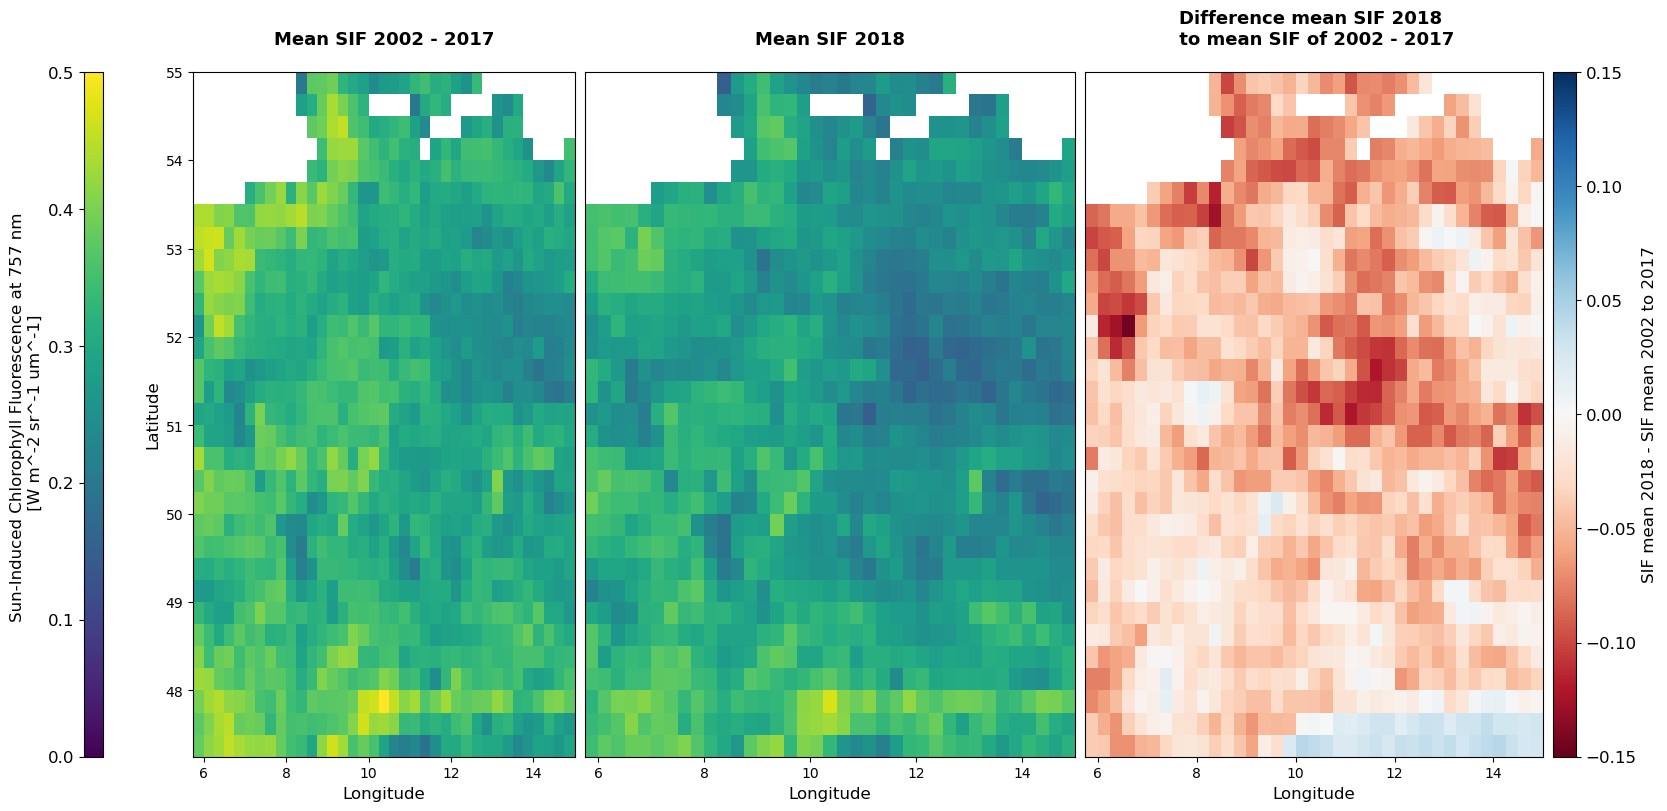

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create the figure and 1x3 subplots
fig, axd = plt.subplot_mosaic([['left1', 'left2', 'right']], layout='constrained', figsize=(15, 8))

# Plot each time slice on a different subplot
img1 = summer_mean_to_2017.plot(ax=axd["left1"], cmap="viridis", vmin=0, vmax=0.5, add_colorbar=False)
#germany_border.plot(ax=axd["left1"], edgecolor='red', facecolor='none')
axd["left1"].set_title("Mean SIF 2002 - 2017", fontsize=13, fontweight='bold', pad=20)
axd["left1"].set_xlabel("Longitude", fontsize=12)
axd["left1"].set_ylabel("Latitude", fontsize=12)

img2 = summer_mean_2018.plot(ax=axd["left2"], cmap="viridis", vmin=0, vmax=0.5, add_colorbar=False)
axd["left2"].set_title("Mean SIF 2018", fontsize=13, fontweight='bold', pad=20)
axd["left2"].set_xlabel("Longitude", fontsize=12)
axd["left2"].set_ylabel("", fontsize=12)
axd["left2"].set_yticks([]) 

img3 = diff_18_baseline.plot(ax=axd["right"], cmap="RdBu", vmin=-0.15, vmax=0.15, add_colorbar=False)
axd["right"].set_title("Difference mean SIF 2018 \n to mean SIF of 2002 - 2017", fontsize=13, fontweight='bold', pad=20)
axd["right"].set_xlabel("Longitude", fontsize=12)
axd["right"].set_ylabel("", fontsize=12)
axd["right"].set_yticks([]) 


# Add colorbars for each subplot
divider1 = make_axes_locatable(axd["left1"])
cax1 = divider1.append_axes("left", size="5%", pad=0.9)
#fig.colorbar(img1, cax=cax1, orientation="vertical").ax.tick_params(labelsize=12)

cbar1 = fig.colorbar(img1, cax=cax1, orientation="vertical")
cbar1.ax.tick_params(labelsize=12)
cbar1.set_label('Sun-Induced Chlorophyll Fluorescence at 757 nm \n [W m^-2 sr^-1 um^-1]', fontsize=12)
cbar1.ax.yaxis.set_label_position('left')
cbar1.ax.yaxis.set_ticks_position('left')

#divider2 = make_axes_locatable(axd["left2"])
#cax2 = divider2.append_axes("right", size="5%", pad=0.1)
#fig.colorbar(img2, cax=cax2, orientation="vertical").ax.tick_params(labelsize=12)

divider3 = make_axes_locatable(axd["right"])
cax3 = divider3.append_axes("right", size="5%", pad=0.1)
#fig.colorbar(img3, cax=cax3, orientation="vertical").ax.tick_params(labelsize=12)
cbar3 = fig.colorbar(img3, cax=cax3, orientation="vertical")
cbar3.ax.tick_params(labelsize=12)
cbar3.set_label('SIF mean 2018 - SIF mean 2002 to 2017', fontsize=12)

# Save the figure to inspect improvements
plt.savefig('plots/dif_2018_plot.png', dpi=300, bbox_inches='tight')

plt.show()


In [17]:
ts_sif = summer_data.mean(dim=('lon', 'lat'))

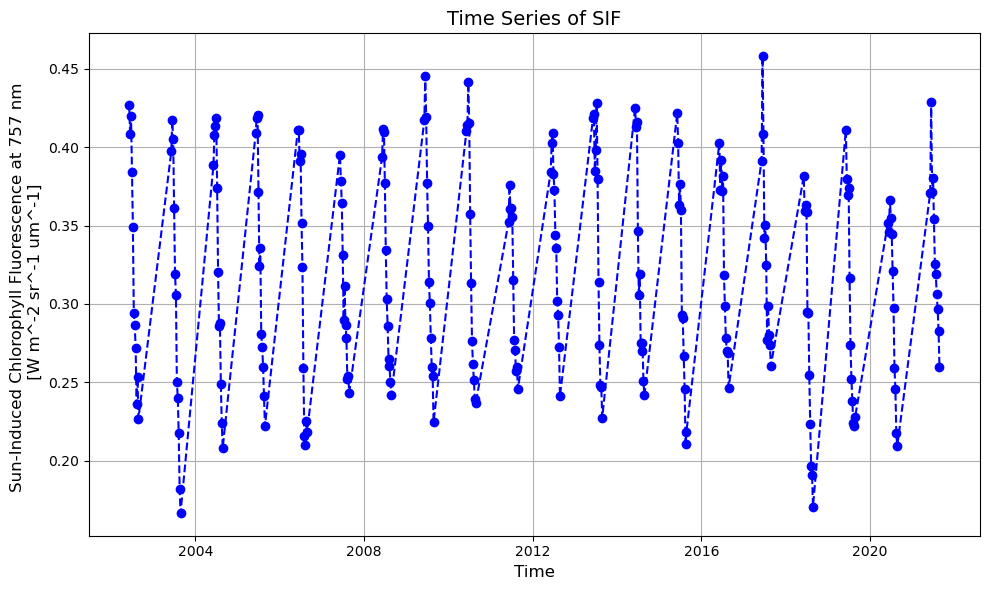

In [18]:
plt.figure(figsize=(10, 6))
ts_sif.plot(marker='o', color='blue', linestyle='dashed')

plt.title(f'Time Series of SIF', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sun-Induced Chlorophyll Fluorescence at 757 nm \n [W m^-2 sr^-1 um^-1]', fontsize=12)
plt.grid(True, which='major', axis='both')
#plt.ylim(.1, .6) 
        
         
plt.tight_layout()
plt.savefig('plots/ts_sif.png', dpi=300, bbox_inches='tight')
plt.show()

# Resample corine data to SIF and create forest mask

In [19]:
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling as Rsp
import rasterio
import numpy as np
import rasterio
from rasterio.windows import Window
from affine import Affine


In [20]:


# Open the landcover raster
with rasterio.open(corine_file_paths[2000]) as src_lc:
    lc_data = src_lc.read()
    lc_transform = src_lc.transform
    lc_crs = src_lc.crs
    lc_meta = src_lc.meta

# Open the sif raster
with rasterio.open(cube_ger_sample_path) as src_sif:
    sif_transform = src_sif.transform
    sif_crs = lc_crs
    sif_meta = src_sif.meta


# Check if CRS of both rasters match
assert lc_crs == sif_crs, "CRS of both rasters must match!"

In [21]:

# Determine the new shape and transform for the resampled raster
new_height = sif_meta['height']
new_width = sif_meta['width']
new_transform = sif_transform
print(new_height)
print(new_width)
print(new_transform)

# Initialize the new resampled data array
resampled_forest_percentage = np.zeros((new_height, new_width), dtype=np.float32)

# Define forest classes
forest_classes = [311, 312, 313]



# Calculate the window size in the original landcover data
window_height = int(abs(sif_transform[4] / lc_transform[4]))
window_width = int(abs(sif_transform[0] / lc_transform[0]))

# print window heights
print(window_height)
print(window_width)
abs(sif_transform[4] / lc_transform[4])

31
37
| 0.25, 0.00, 5.75|
| 0.00, 0.25, 47.25|
| 0.00, 0.00, 1.00|
55
55


55.65974539663678

In [22]:

def calculate_forest_percentage(lc_window, lc_data, forest_classes):
    forest_mask = np.isin(lc_data[lc_window.row_off:lc_window.row_off + lc_window.height,
                                  lc_window.col_off:lc_window.col_off + lc_window.width],
                          forest_classes)

                          
    total_pixels = forest_mask.size
    forest_pixels = np.sum(forest_mask)

    percentage = (forest_pixels / total_pixels) * 100
    return percentage

In [23]:


# Loop through each cell in the sif raster resolution
for i in range(new_height):
    for j in range(new_width):
        # Define the window in the landcover data
        window = Window(col_off=j*window_width, row_off=i*window_height, width=window_width, height=window_height)
        
        # Calculate the forest percentage in the window
        forest_percentage = calculate_forest_percentage(window, lc_data.squeeze(), forest_classes)
        
        # Assign the percentage to the resampled data array
        resampled_forest_percentage[i, j] = forest_percentage


# Plot

In [24]:
forest_mask = np.isin(lc_data, [311, 312, 313]).astype(int).squeeze()

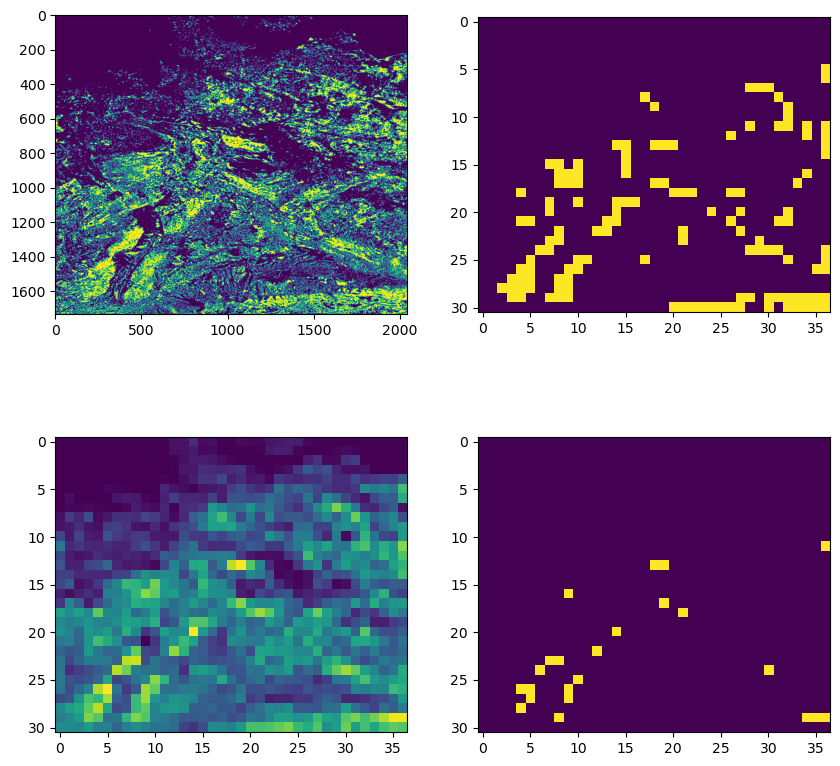

In [25]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(forest_mask.squeeze())
axs[0,1].imshow(np.where(resampled_forest_percentage>=50,1,0).squeeze())
axs[1,0].imshow(resampled_forest_percentage.squeeze())
axs[1,1].imshow(np.where(resampled_forest_percentage>=70,1,0).squeeze())
fig.set_size_inches(10,10)

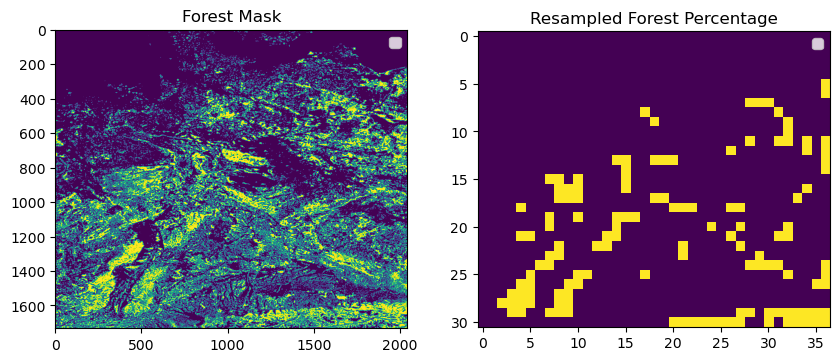

In [26]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(forest_mask)
axs[0].set_title('Forest Mask')
axs[0].legend(['Forest Mask'], loc='upper right')
axs[1].imshow(np.where(resampled_forest_percentage>=50,1,0))
axs[1].set_title('Resampled Forest Percentage')
axs[1].legend(['>= 50% Forest'], loc='upper right')
fig.set_size_inches(10,10)

# Cut with germany border

In [27]:
dims = ('lat', 'lon')  # Replace with your dataset's dimension names
resampled_forest_percentage_flip = np.flipud(resampled_forest_percentage)
cube_ger['forest_cover'] = xr.DataArray(resampled_forest_percentage_flip, dims=dims, coords={dim: cube_ger.coords[dim] for dim in dims})
cube_ger['forest_cover_50'] = xr.DataArray((resampled_forest_percentage_flip>=50).astype(int), dims=dims, coords={dim: cube_ger.coords[dim] for dim in dims})


In [28]:
cube_ger

<xarray.Dataset> Size: 30MB
Dimensions:                 (time: 920, lat: 31, lon: 37)
Coordinates:
  * lat                     (lat) float64 248B 47.38 47.62 47.88 ... 54.62 54.88
  * lon                     (lon) float64 296B 5.875 6.125 6.375 ... 14.62 14.88
  * time                    (time) datetime64[ns] 7kB 2002-01-05 ... 2021-12-31
Data variables:
    evaporation_era5        (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    precipitation_era5      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    radiation_era5          (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    air_temperature_2m      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    max_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    min_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    sif_gosif               (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    forest_cover            (lat, lon) float32 5kB 41.92 41.88 ... 0.0 0.2314
    forest_cover_50         (lat, lon) int64 9kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

In [29]:
cube_ger_forestf = cube_ger.where(cube_ger.forest_cover_50 == 1, drop=False).rio.write_crs(4326)
cube_ger_forestf

<xarray.Dataset> Size: 30MB
Dimensions:                 (time: 920, lat: 31, lon: 37)
Coordinates:
  * lat                     (lat) float64 248B 47.38 47.62 47.88 ... 54.62 54.88
  * lon                     (lon) float64 296B 5.875 6.125 6.375 ... 14.62 14.88
  * time                    (time) datetime64[ns] 7kB 2002-01-05 ... 2021-12-31
    spatial_ref             int64 8B 0
Data variables:
    evaporation_era5        (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    precipitation_era5      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    radiation_era5          (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    air_temperature_2m      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    max_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    min_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    sif_gosif               (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    forest_cover            (lat, lon) float32 5kB nan nan nan ... nan nan nan
    forest_cover_50         (lat, lon) float64 9kB nan nan nan ... nan nan nan
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

In [30]:
# Clip the xarray dataset using the shapefile geometry
all_touched = True
cube_ger_forestf_crop = cube_ger_forestf.rio.clip(germany_border.geometry.values,germany_border.crs,
                                                               drop = False, all_touched = all_touched)

In [31]:
cube_ger_forestf_crop

<xarray.Dataset> Size: 30MB
Dimensions:                 (lat: 31, lon: 37, time: 920)
Coordinates:
  * lat                     (lat) float64 248B 47.38 47.62 47.88 ... 54.62 54.88
  * lon                     (lon) float64 296B 5.875 6.125 6.375 ... 14.62 14.88
  * time                    (time) datetime64[ns] 7kB 2002-01-05 ... 2021-12-31
    spatial_ref             int64 8B 0
Data variables:
    evaporation_era5        (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    precipitation_era5      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    radiation_era5          (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    air_temperature_2m      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    max_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    min_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    sif_gosif               (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    forest_cover            (lat, lon) float32 5kB nan nan nan ... nan nan nan
    forest_cover_50         (lat, lon) float64 9kB nan nan nan ... nan nan nan
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

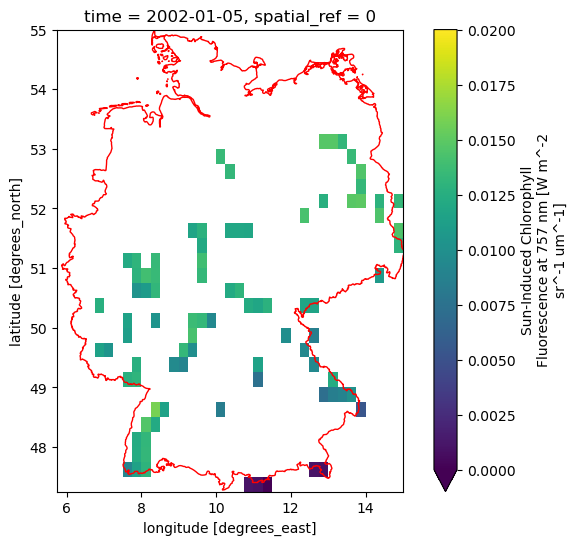

In [33]:
import matplotlib.pyplot as plt
import os

fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(8, 6))  # Adjust the size as needed
cube_ger_forestf_crop.sif_gosif.isel(time=0).plot(ax=axs, vmin=0,vmax=0.02)
germany_border.plot(ax=axs, edgecolor='red', facecolor='none')  # Adjust colors as needed

# Save the plot
folder_path = 'plots'

file_name = 'cube_ger_forestf_crop.jpg'  # Name of the file
file_path = os.path.join(folder_path, file_name)
plt.savefig(file_path)

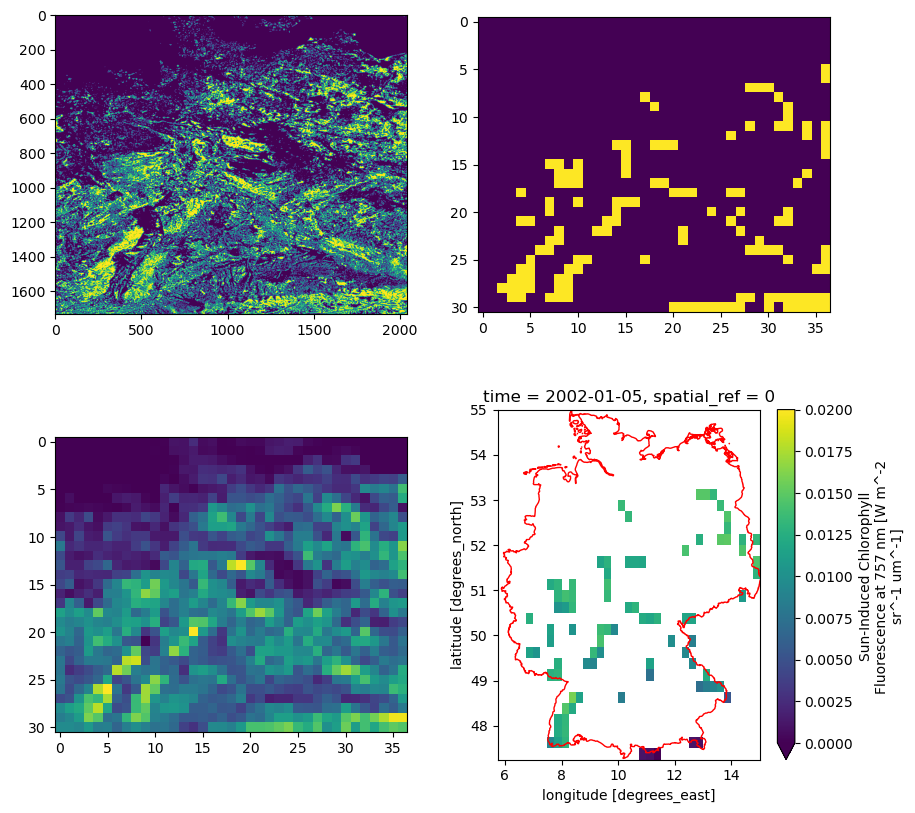

In [29]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(forest_mask.squeeze())
axs[0,1].imshow(np.where(resampled_forest_percentage>=50,1,0).squeeze())
axs[1,0].imshow(resampled_forest_percentage.squeeze())
cube_ger_forestf_crop.sif_gosif.isel(time=0).plot(ax=axs[1,1], vmin=0,vmax=0.02)
germany_border.plot(ax=axs[1,1], edgecolor='red', facecolor='none')  # Adjust colors as needed
fig.set_size_inches(10,10)

# Add forest_cover data with functions

In [30]:

def f_percentage_window(lc_window, lc_data, forest_class):
    forest_mask = np.isin(lc_data[lc_window.row_off:lc_window.row_off + lc_window.height,
                                  lc_window.col_off:lc_window.col_off + lc_window.width],
                          forest_class)

                          
    total_pixels = forest_mask.size
    forest_pixels = np.sum(forest_mask)

    percentage = (forest_pixels / total_pixels) * 100
    return percentage

In [31]:
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling as Rsp
import rasterio
import numpy as np
import rasterio
from rasterio.windows import Window
from affine import Affine


def get_forest_percentage(lc_data_path, sample_cube_slice_path, forest_class):
        

    # Open the landcover raster
    with rasterio.open(lc_data_path) as src_lc:
        lc_data = src_lc.read()
        lc_transform = src_lc.transform
        lc_crs = src_lc.crs
        lc_meta = src_lc.meta

    # Open the sif raster
    with rasterio.open(sample_cube_slice_path) as src_sif:
        sif_transform = src_sif.transform
        sif_crs = lc_crs
        sif_meta = src_sif.meta


    # Check if CRS of both rasters match
    assert lc_crs == sif_crs, "CRS of both rasters must match!"


    # Determine the new shape and transform for the resampled raster
    new_height = sif_meta['height']
    new_width = sif_meta['width']
    new_transform = sif_transform


    # Calculate the window size in the original landcover data by dividing resolutions
    window_height = int(abs(sif_transform[4] / lc_transform[4]))
    window_width = int(abs(sif_transform[0] / lc_transform[0]))
    
    # Initialize the new resampled data array
    resampled_forest_percentage = np.zeros((new_height, new_width), dtype=np.float32)

    # Loop through each cell in the sif raster resolution
    for i in range(new_height):
        for j in range(new_width):
            # Define the window in the landcover data
            window = Window(col_off=j*window_width, row_off=i*window_height, width=window_width, height=window_height)
            
            # Calculate the forest percentage in the window
            forest_percentage = f_percentage_window(window, lc_data.squeeze(), forest_class)
  
            # Assign the percentage to the resampled data array
            resampled_forest_percentage[i, j] = forest_percentage
            
    return np.flipud(resampled_forest_percentage)

### Apply function over all years

In [32]:
# Define forest classes
forest_classes = [311, 312, 313]
forest_cover_data = []

# Loop through each year and calculate the forest cover percentage
for year in years:
    resampled_forest_percentage_all = get_forest_percentage(corine_file_paths[year], cube_ger_sample_path, forest_classes)
    resampled_forest_percentage_311 = get_forest_percentage(corine_file_paths[year], cube_ger_sample_path, [311])
    resampled_forest_percentage_312 = get_forest_percentage(corine_file_paths[year], cube_ger_sample_path, [312])
    resampled_forest_percentage_313 = get_forest_percentage(corine_file_paths[year], cube_ger_sample_path, [313])
    percentages_list = [resampled_forest_percentage_311,resampled_forest_percentage_312,resampled_forest_percentage_313,resampled_forest_percentage_all]

    assert(np.all(np.round(np.sum(percentages_list[:-1], axis=0),3)==np.round(percentages_list[-1],3)))
    
    
    forest_cover_data.append(percentages_list)

forest_cover_data = np.asarray(forest_cover_data)

In [33]:
forest_cover_data_shape = forest_cover_data.shape
forest_cover_data_shape
# class, timestep, lat, lon 

(4, 4, 31, 37)

In [34]:
forest_cover_data[0][0][0][0]

36.19835

### Add data to cube

In [35]:

# Dimensions of the data
dims = ('lat', 'lon')

# Coordinates for latitude and longitude from the cube
coords_lc_data = {dim: cube_ger.coords[dim] for dim in dims}
time_coords_forest = pd.to_datetime([f'{year}-01-01' for year in years])
classes = ["deciduous","coniferous","mixed","all_classes"]
# Combine the data into one DataArray with the correct time coordinate type
forest_cover = xr.DataArray(forest_cover_data, dims=('time','classes', 'lat', 'lon'), 
                            coords={'time': time_coords_forest, 'classes':classes,'lat': coords_lc_data['lat'], 'lon': coords_lc_data['lon']})


In [36]:
forest_cover

<xarray.DataArray (time: 4, classes: 4, lat: 31, lon: 37)> Size: 73kB
array([[[[3.6198349e+01, 3.8314049e+01, 3.6892563e+01, ...,
          3.3057851e-01, 1.7520661e+00, 1.8181819e+00],
         [3.4016529e+01, 3.8809917e+01, 3.9239670e+01, ...,
          2.2942148e+01, 1.2429752e+01, 7.2396693e+00],
         [3.4314049e+01, 3.8743801e+01, 2.0859505e+01, ...,
          1.1305785e+01, 2.6446280e+00, 4.4958677e+00],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

        [[3.7685950e+00, 7.2727275e-01, 1.6528926e+00, ...,
          5.4909092e+01, 5.1603306e+01, 4.4694214e+01],
         [1.8512397e+00, 4.6280992e-01, 2.4793389e+00, ...,
          2.6380165e+01, 3.6231403e+01, 4.1388432e+01],
         [5.0247936e+00, 5.0909090e+00, 1.9966942e+01, ...,
          2.0826447e+00, 8.3636360e+00, 4.8595042e+00],
...
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.3223140e-01]],

        [[4.0528927e+01, 4.2413223e+01, 3.9768597e+01, ...,
          5.6991737e+01, 6.1123966e+01, 6.4694214e+01],
         [3.7256199e+01, 3.9834709e+01, 4.8231403e+01, ...,
          7.5272728e+01, 8.2876030e+01, 8.2115700e+01],
         [4.2677685e+01, 4.8694214e+01, 5.2198349e+01, ...,
          3.0512396e+01, 2.5487604e+01, 3.2297520e+01],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 3.6363637e-01]]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 32B 2000-01-01 2006-01-01 ... 2018-01-01
  * classes  (classes) <U11 176B 'deciduous' 'coniferous' 'mixed' 'all_classes'
  * lat      (lat) float64 248B 47.38 47.62 47.88 48.12 ... 54.38 54.62 54.88
  * lon      (lon) float64 296B 5.875 6.125 6.375 6.625 ... 14.38 14.62 14.88

In [37]:
forest_cover_ds = forest_cover.to_dataset(dim="classes")
forest_cover_ds

<xarray.Dataset> Size: 74kB
Dimensions:      (time: 4, lat: 31, lon: 37)
Coordinates:
  * time         (time) datetime64[ns] 32B 2000-01-01 2006-01-01 ... 2018-01-01
  * lat          (lat) float64 248B 47.38 47.62 47.88 ... 54.38 54.62 54.88
  * lon          (lon) float64 296B 5.875 6.125 6.375 ... 14.38 14.62 14.88
Data variables:
    deciduous    (time, lat, lon) float32 18kB 36.2 38.31 36.89 ... 0.0 0.0 0.0
    coniferous   (time, lat, lon) float32 18kB 3.769 0.7273 1.653 ... 0.0 0.2314
    mixed        (time, lat, lon) float32 18kB 1.95 2.843 1.355 ... 0.0 0.1322
    all_classes  (time, lat, lon) float32 18kB 41.92 41.88 39.9 ... 0.0 0.3636

In [38]:
combined_cube = xr.merge([cube_ger, forest_cover_ds])
combined_cube

<xarray.Dataset> Size: 47MB
Dimensions:                 (lat: 31, lon: 37, time: 924)
Coordinates:
  * lat                     (lat) float64 248B 47.38 47.62 47.88 ... 54.62 54.88
  * lon                     (lon) float64 296B 5.875 6.125 6.375 ... 14.62 14.88
  * time                    (time) datetime64[ns] 7kB 2000-01-01 ... 2021-12-31
Data variables: (12/13)
    evaporation_era5        (time, lat, lon) float32 4MB dask.array<chunksize=(224, 31, 25), meta=np.ndarray>
    precipitation_era5      (time, lat, lon) float32 4MB dask.array<chunksize=(224, 31, 25), meta=np.ndarray>
    radiation_era5          (time, lat, lon) float32 4MB dask.array<chunksize=(224, 31, 25), meta=np.ndarray>
    air_temperature_2m      (time, lat, lon) float32 4MB dask.array<chunksize=(224, 31, 25), meta=np.ndarray>
    max_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(224, 31, 25), meta=np.ndarray>
    min_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(224, 31, 25), meta=np.ndarray>
    ...                      ...
    forest_cover            (lat, lon) float32 5kB 41.92 41.88 ... 0.0 0.2314
    forest_cover_50         (lat, lon) int64 9kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    deciduous               (time, lat, lon) float32 4MB 36.2 38.31 ... nan nan
    coniferous              (time, lat, lon) float32 4MB 3.769 0.7273 ... nan
    mixed                   (time, lat, lon) float32 4MB 1.95 2.843 ... nan nan
    all_classes             (time, lat, lon) float32 4MB 41.92 41.88 ... nan nan
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

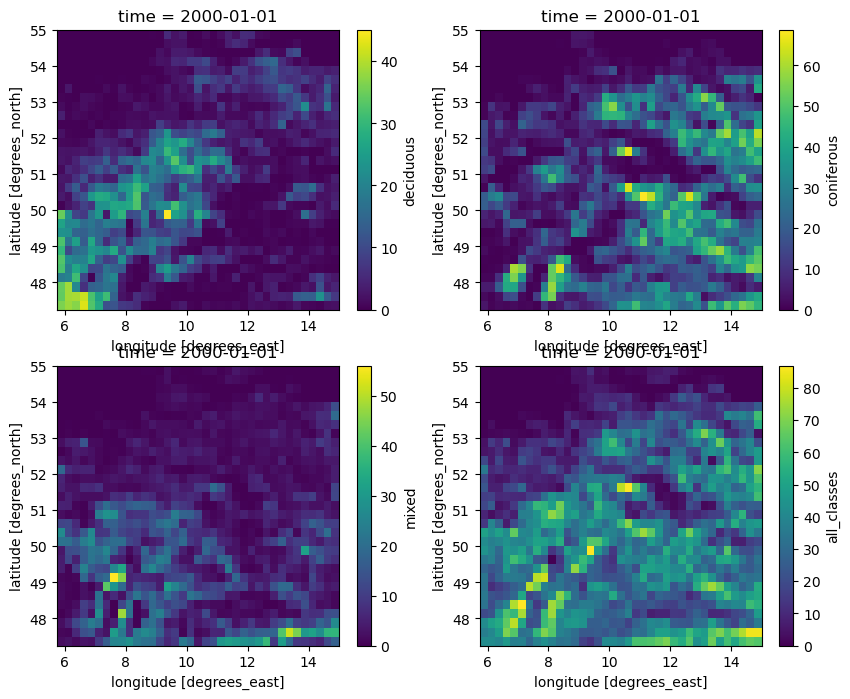

In [39]:
fig, axs = plt.subplots(2,2,figsize = (10,8))
combined_cube.deciduous.isel(time=0).plot(ax = axs[0,0])
combined_cube.coniferous.isel(time=0).plot(ax = axs[0,1])
combined_cube.mixed.isel(time=0).plot(ax = axs[1,0])
combined_cube.all_classes.isel(time=0).plot(ax = axs[1,1])


# Trying to interpolate

In [40]:
forest_full_time = combined_cube[classes]
forest_full_time.isel(time=1)

<xarray.Dataset> Size: 19kB
Dimensions:      (lat: 31, lon: 37)
Coordinates:
  * lat          (lat) float64 248B 47.38 47.62 47.88 ... 54.38 54.62 54.88
  * lon          (lon) float64 296B 5.875 6.125 6.375 ... 14.38 14.62 14.88
    time         datetime64[ns] 8B 2002-01-05
Data variables:
    deciduous    (lat, lon) float32 5kB nan nan nan nan nan ... nan nan nan nan
    coniferous   (lat, lon) float32 5kB nan nan nan nan nan ... nan nan nan nan
    mixed        (lat, lon) float32 5kB nan nan nan nan nan ... nan nan nan nan
    all_classes  (lat, lon) float32 5kB nan nan nan nan nan ... nan nan nan nan
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

In [41]:
# check how forest cover changed
forest_full_time.all_classes.isel(time=0)>forest_full_time.all_classes.sel(time="2006-01-01")

<xarray.DataArray 'all_classes' (lat: 31, lon: 37)> Size: 1kB
array([[ True, False,  True, ..., False,  True, False],
       [ True,  True,  True, ..., False, False,  True],
       [False,  True,  True, ...,  True, False,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lat      (lat) float64 248B 47.38 47.62 47.88 48.12 ... 54.38 54.62 54.88
  * lon      (lon) float64 296B 5.875 6.125 6.375 6.625 ... 14.38 14.62 14.88

### Compare if use_coordinate leads to interpolation considering distances in time not index

When decrease from index 0 to 1, then use_coordinates = True should show a greater difference, as time not index is considered for interpolation

In [42]:
 forest_interpolated = forest_full_time.interpolate_na(dim='time', method='linear', limit=None,
                                                     use_coordinate = False)
forest_interpolated.all_classes.isel(time=1)

<xarray.DataArray 'all_classes' (lat: 31, lon: 37)> Size: 5kB
array([[41.916996  , 41.88608   , 39.900646  , ..., 60.92598   ,
        65.50547   , 63.4155    ],
       [36.75872   , 40.13152   , 48.031807  , ..., 76.50051   ,
        85.12397   , 85.18008   ],
       [41.45955   , 49.056957  , 52.956715  , ..., 31.169802  ,
        25.52066   , 35.913692  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.23176235]], dtype=float32)
Coordinates:
  * lat      (lat) float64 248B 47.38 47.62 47.88 48.12 ... 54.38 54.62 54.88
  * lon      (lon) float64 296B 5.875 6.125 6.375 6.625 ... 14.38 14.62 14.88
    time     datetime64[ns] 8B 2002-01-05

In [43]:
forest_interpolated = forest_full_time.interpolate_na(dim='time', method='linear', limit=None,
                                                     use_coordinate = True)
forest_interpolated.all_classes.isel(time=1)

<xarray.DataArray 'all_classes' (lat: 31, lon: 37)> Size: 5kB
array([[41.895184  , 41.995144  , 39.88974   , ..., 60.947792  ,
        64.57847   , 64.05895   ],
       [36.66057   , 40.087894  , 47.955463  , ..., 76.784065  ,
        85.12397   , 84.56934   ],
       [41.764915  , 49.002426  , 52.83675   , ..., 30.940777  ,
        25.52066   , 34.68132   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.25357422]], dtype=float32)
Coordinates:
  * lat      (lat) float64 248B 47.38 47.62 47.88 48.12 ... 54.38 54.62 54.88
  * lon      (lon) float64 296B 5.875 6.125 6.375 6.625 ... 14.38 14.62 14.88
    time     datetime64[ns] 8B 2002-01-05

### Fill values after 2018 with same as 2018

In [44]:
forest_interpolated_ff = forest_interpolated.ffill(dim="time")
assert(np.all(forest_interpolated_ff.all_classes.isel(time=923) == forest_interpolated_ff.all_classes.sel(time="2018-01-01")))
forest_interpolated_ff

ModuleNotFoundError: No module named 'bottleneck'

### Remove landcover time values

In [24]:
time_coords_forest

DatetimeIndex(['2000-01-01', '2006-01-01', '2012-01-01', '2018-01-01'], dtype='datetime64[ns]', freq=None)

In [25]:
forest_imterpolated_ff = forest_interpolated_ff.drop_sel(time=time_coords_forest)
forest_imterpolated_ff

<xarray.Dataset> Size: 17MB
Dimensions:      (lat: 31, lon: 37, time: 920)
Coordinates:
  * lat          (lat) float64 248B 47.38 47.62 47.88 ... 54.38 54.62 54.88
  * lon          (lon) float64 296B 5.875 6.125 6.375 ... 14.38 14.62 14.88
  * time         (time) datetime64[ns] 7kB 2002-01-05 2002-01-13 ... 2021-12-31
Data variables:
    deciduous    (time, lat, lon) float32 4MB 36.2 38.4 36.93 ... 0.0 0.0 0.0
    coniferous   (time, lat, lon) float32 4MB 3.769 0.7273 1.609 ... 0.0 0.2314
    mixed        (time, lat, lon) float32 4MB 1.928 2.865 1.355 ... 0.0 0.1322
    all_classes  (time, lat, lon) float32 4MB 41.9 42.0 39.89 ... 0.0 0.0 0.3636
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

Combine Original Cube with updated forest cover cube

In [26]:
combined_cube = xr.merge([cube_ger, forest_imterpolated_ff])
combined_cube

<xarray.Dataset> Size: 46MB
Dimensions:                 (time: 920, lat: 31, lon: 37)
Coordinates:
  * lat                     (lat) float64 248B 47.38 47.62 47.88 ... 54.62 54.88
  * lon                     (lon) float64 296B 5.875 6.125 6.375 ... 14.62 14.88
  * time                    (time) datetime64[ns] 7kB 2002-01-05 ... 2021-12-31
Data variables:
    evaporation_era5        (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    precipitation_era5      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    radiation_era5          (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    air_temperature_2m      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    max_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    min_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    sif_gosif               (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    deciduous               (time, lat, lon) float32 4MB 36.2 38.4 ... 0.0 0.0
    coniferous              (time, lat, lon) float32 4MB 3.769 0.7273 ... 0.2314
    mixed                   (time, lat, lon) float32 4MB 1.928 2.865 ... 0.1322
    all_classes             (time, lat, lon) float32 4MB 41.9 42.0 ... 0.3636
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

In [27]:
# Get the size in bytes
size_in_bytes = combined_cube.nbytes

# Convert the size to more readable units (e.g., megabytes)
size_in_megabytes = size_in_bytes / (1024 ** 2)

print(size_in_megabytes)

44.28717041015625


### Crop combined cube with germany broder

In [32]:
combined_cube.rio.write_crs(4326, inplace = True)
cube_ger_f_crop = combined_cube.rio.clip(germany_gpd.geometry.values,germany_gpd.crs,
                                                               drop = False, all_touched = False)

cube_ger_f_crop

<xarray.Dataset> Size: 46MB
Dimensions:                 (lat: 31, lon: 37, time: 920)
Coordinates:
  * lat                     (lat) float64 248B 47.38 47.62 47.88 ... 54.62 54.88
  * lon                     (lon) float64 296B 5.875 6.125 6.375 ... 14.62 14.88
  * time                    (time) datetime64[ns] 7kB 2002-01-05 ... 2021-12-31
    spatial_ref             int64 8B 0
Data variables:
    evaporation_era5        (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    precipitation_era5      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    radiation_era5          (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    air_temperature_2m      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    max_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    min_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    sif_gosif               (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    deciduous               (time, lat, lon) float32 4MB nan nan nan ... nan nan
    coniferous              (time, lat, lon) float32 4MB nan nan nan ... nan nan
    mixed                   (time, lat, lon) float32 4MB nan nan nan ... nan nan
    all_classes             (time, lat, lon) float32 4MB nan nan nan ... nan nan
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

In [ ]:
combined_cube.to_netcdf(os.path.join("data","processed","cube_preprocessed.nc"))

In [33]:
cube_ger_f_crop.to_netcdf(os.path.join("data","processed","cube_preprocessed_crop.nc"))

# Old

In [ ]:
dims = ('lat', 'lon')  # Replace with your dataset's dimension names
coords_lc_data = {dim: cube_ger.coords[dim] for dim in dims}
resampled_forest_percentage_flip = np.flipud(resampled_forest_percentage)
cube_ger['forest_cover'] = xr.DataArray(resampled_forest_percentage_flip, dims=dims, coords=coords_lc_data)
cube_ger['forest_cover_50'] = xr.DataArray((resampled_forest_percentage_flip>=50).astype(int), dims=dims, coords={dim: cube_ger.coords[dim] for dim in dims})


In [ ]:
germany_mask = geometry_mask(germany_border.geometry.values,
                         out_shape=(len(cube_ger_forestf.lat), len(cube_ger_forestf.lon)),
                         transform=cube_ger_forestf.rio.transform(),
                         all_touched=False,
                         invert=True)

# Apply the mask to the dataset
cube_ger_forestf_masked = cube_ger_forestf.where(mask, np.nan, drop = False)
cube_ger_forestf_masked